In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, cols, use_threads=True):
    try:
        return pq.read_table(path, columns=cols, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols,dtypes):

    df = load_df(path,cols)
    df = df.astype(dtypes)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
def boxPlotPPMFiltered(dfOG,dfPos,dfNeg,val,var,xaxis,maxTopTop,maxTopBot):

    #get the top/bot 5 for our top/bot ppm
    dfTop5 = dfPos.drop(['average_ppm','std','count'], axis=1).head(5)
    dfBot5 = dfNeg.drop(['average_ppm','std','count'], axis=1).tail(5)
    
    #inner join with original values to get the filtered list
    dfJoinPos = pd.merge(dfOG, dfTop5, left_on=[var,'direction'], right_on=[var,'direction'], how='inner')
    dfJoinNeg = pd.merge(dfOG, dfBot5, left_on=[var,'direction'], right_on=[var,'direction'], how='inner')
    #filter
    dfJoinPosDir = dfJoinPos.loc[(dfJoinPos['direction'] == 1)]
    dfJoinNegDir = dfJoinNeg.loc[(dfJoinNeg['direction'] == -1)]                                                                               
                                                                                   
    fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(15,8))

    #plot for top5
    bplotTop=sns.violinplot(y=val, x=var, data=dfJoinPos, width=1, palette="colorblind", cut = 0, ax=axes[0])
    #bplotTop=sns.stripplot(y=val, x=var, data=dfJoinTop, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[0])
    bplotTop.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel("(+) PPM",fontsize=15)
    bplotTop.tick_params(labelsize=14)
    axes[0].set_ylim(0, maxTopTop)
    
    #plot for bot5
    bplotBot=sns.violinplot(y=val, x=var, data=dfJoinNeg, width=1, palette="colorblind", cut=0, ax=axes[1])
    #bplotBot=sns.stripplot(y=val, x=var, data=dfJoinBot, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[1])
    bplotBot.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotBot.set_xticklabels(bplotBot.get_xticklabels(),rotation=60)
    bplotBot.set_ylabel("(-) PPM",fontsize=15)
    bplotBot.tick_params(labelsize=14)
    axes[1].set_ylim(0, maxTopBot)
    
    plt.show()
    
    
def boxPlotPPMAll(df,val,var,yaxis,xaxis,maxTop):

    fig, ax = plt.subplots(1,figsize=(7,8))
    bplotTop=sns.violinplot(y=val, x=var, data=df, width=1, palette="colorblind", cut=0, ax=ax)
    #bplotTop=sns.stripplot(y=val, x=var, data=df, jitter=True, marker='o', alpha=0.5, color='black')
    bplotTop.set_xlabel(xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    ax.set_ylim(0, maxTop)
    
    bplotTop.figure

In [4]:
cols1 = ['sample_id', 'name', 'sub', 'label']
dtypes1 = {'sample_id' : 'uint32', 'name' : 'category', 'sub' : 'category', 'label' : 'category'}
dfApps = prepare('2-datasets/top15Apps.parquet',cols1,dtypes1)
dfApps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159935697 entries, 0 to 159935696
Data columns (total 4 columns):
sample_id    uint32
name         category
sub          category
label        category
dtypes: category(3), uint32(1)
memory usage: 1.0 GB


In [5]:
#cols2 = ['id','device_id', 'timestamp', 'battery_level', 'network_status', 'screen_brightness', 'screen_on', 'timezone', 'country_code', 'period', 'size', 'direction', 'ppm']
cols2 = ['id', 'period', 'direction', 'ppm']
dtypes2 = {'id' : 'int32', 'period' : 'uint32', 'direction' : 'float64', 'ppm' : 'float32'}
dfSamples = prepare('2-datasets/samplesPPM.parquet',cols2,dtypes2)
dfSamples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17675718 entries, 0 to 17675717
Data columns (total 4 columns):
id           int32
period       uint32
direction    float64
ppm          float32
dtypes: float32(1), float64(1), int32(1), uint32(1)
memory usage: 337.1 MB


In [6]:
df_inner = pd.merge(dfSamples, dfApps, left_on='id', right_on='sample_id', how='inner')

In [7]:
df_inner.head(100)

,id,period,direction,ppm,sample_id,name,sub,label
0,447027,1,-1.0,0.2026,447027,com.google.android.music,main,google play music
1,447027,1,-1.0,0.2026,447027,com.facebook.katana,videoplayer,facebook
2,447027,1,-1.0,0.2026,447027,com.facebook.orca,videoplayer,messenger
3,447027,1,-1.0,0.2026,447027,com.facebook.katana,core_app,facebook
4,447027,1,-1.0,0.2026,447027,com.facebook.orca,core_app,messenger
...,...,...,...,...,...,...,...,...
95,443528,2,-1.0,0.1869,443528,com.google.android.googlequicksearchbox,interactor,google
96,443525,2,-1.0,0.1869,443525,com.google.android.music,main,google play music
97,443525,2,-1.0,0.1869,443525,com.facebook.katana,videoplayer,facebook
98,443525,2,-1.0,0.1869,443525,com.facebook.orca,videoplayer,messenger


In [8]:
df_inner_droppedDup = df_inner.drop(['id','sample_id'], axis=1).drop_duplicates()

In [9]:
def processesGroupBy(dataframe, var, direction):
    df = dataframe.groupby([var,'direction'])['ppm'].agg(average_ppm='mean', std='std', count='count').reset_index().sort_values(['average_ppm'], ascending=False)
    return df.loc[(df['direction'] == direction)]

dfLabelGBPos = processesGroupBy(df_inner_droppedDup, 'label', 1)
dfLabelGBNeg = processesGroupBy(df_inner_droppedDup, 'label', -1)

dfFacebook = df_inner_droppedDup.loc[df_inner_droppedDup['label'] == "facebook"]
dfMessenger = df_inner_droppedDup.loc[df_inner_droppedDup['label'] == "messenger"]
dfInstagram = df_inner_droppedDup.loc[df_inner_droppedDup['label'] == "instagram"]

dfFacebookGBPos = processesGroupBy(dfFacebook, 'sub', 1).sort_values(['count'], ascending=False).head(5).sort_values(['average_ppm'], ascending=False)
dfFacebookGBNeg = processesGroupBy(dfFacebook, 'sub', -1).sort_values(['count'], ascending=False).head(5).sort_values(['average_ppm'], ascending=False)

dfMessengerGBPos = processesGroupBy(dfMessenger, 'sub', 1).sort_values(['count'], ascending=False).head(5).sort_values(['average_ppm'], ascending=False)
dfMessengerGBNeg = processesGroupBy(dfMessenger, 'sub', -1).sort_values(['count'], ascending=False).head(5).sort_values(['average_ppm'], ascending=False)

dfInstagramGBPos = processesGroupBy(dfInstagram, 'sub', 1).sort_values(['count'], ascending=False).head(5).sort_values(['average_ppm'], ascending=False)
dfInstagramGBNeg = processesGroupBy(dfInstagram, 'sub', -1).sort_values(['count'], ascending=False).head(5).sort_values(['average_ppm'], ascending=False)


                label  direction  average_ppm       std   count
21          messenger        1.0     0.647972  0.385032  220126
5            facebook        1.0     0.644981  0.382111  256774
7             fb lite        1.0     0.639333  0.434238   86649
17          instagram        1.0     0.636306  0.380997  172196
11             google        1.0     0.630854  0.391011  457491
3    es file explorer        1.0     0.629023  0.405217   21788
27           whatsapp        1.0     0.628312  0.391783  128741
23            shareit        1.0     0.623830  0.404298  106338
1              chrome        1.0     0.623016  0.374196  267733
9              gboard        1.0     0.616438  0.376864   70012
13  google play music        1.0     0.614619  0.369681  194945
15           hangouts        1.0     0.607666  0.374352   83885
29            youtube        1.0     0.606063  0.395109   75563
25            vidmate        1.0     0.603317  0.406800   69049
19               maps        1.0     0.5

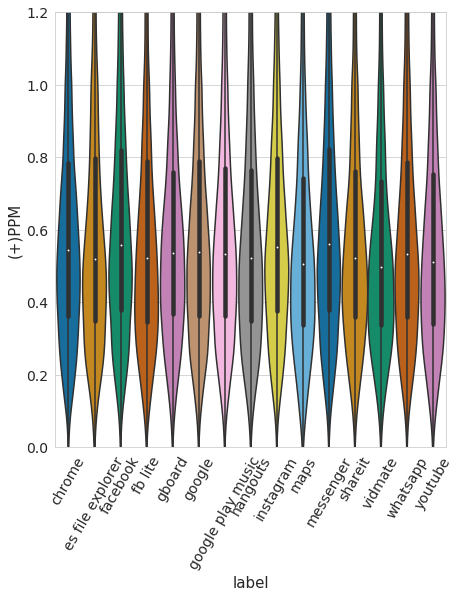

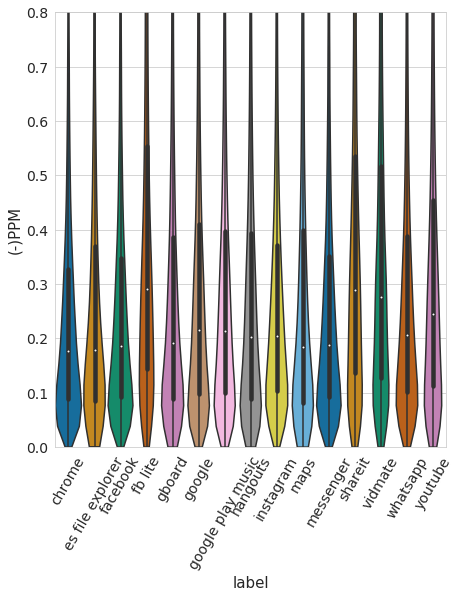

In [13]:
print(dfLabelGBPos); 
dfJoinPosAll = pd.merge(df_inner_droppedDup.loc[df_inner_droppedDup['direction'] == 1], dfLabelGBPos, left_on='label', right_on='label', how='inner').drop(['average_ppm','std','count','direction_y'], axis=1)
boxPlotPPMAll(dfJoinPosAll,'ppm','label','(+)PPM','label',1.2)

print(dfLabelGBNeg);
dfJoinNegAll = pd.merge(df_inner_droppedDup.loc[df_inner_droppedDup['direction'] == -1], dfLabelGBNeg, left_on='label', right_on='label', how='inner').drop(['average_ppm','std','count','direction_y'], axis=1)
boxPlotPPMAll(dfJoinNegAll,'ppm','label','(-)PPM','label',0.8)



              sub  direction  average_ppm       std     count
57   notification        1.0     0.684189  0.390760   60029.0
175   videoplayer        1.0     0.659442  0.387867   70341.0
7         browser        1.0     0.637945  0.338318     490.0
11       core_app        1.0     0.618328  0.372655  123518.0
59         optsvc        1.0     0.611933  0.366951    2114.0
              sub  direction  average_ppm       std     count
58         optsvc       -1.0     0.363728  0.382519    2688.0
10       core_app       -1.0     0.307102  0.355412  129907.0
56   notification       -1.0     0.256087  0.270033   53605.0
174   videoplayer       -1.0     0.251669  0.273126   81295.0
6         browser       -1.0     0.214142  0.239477    1870.0


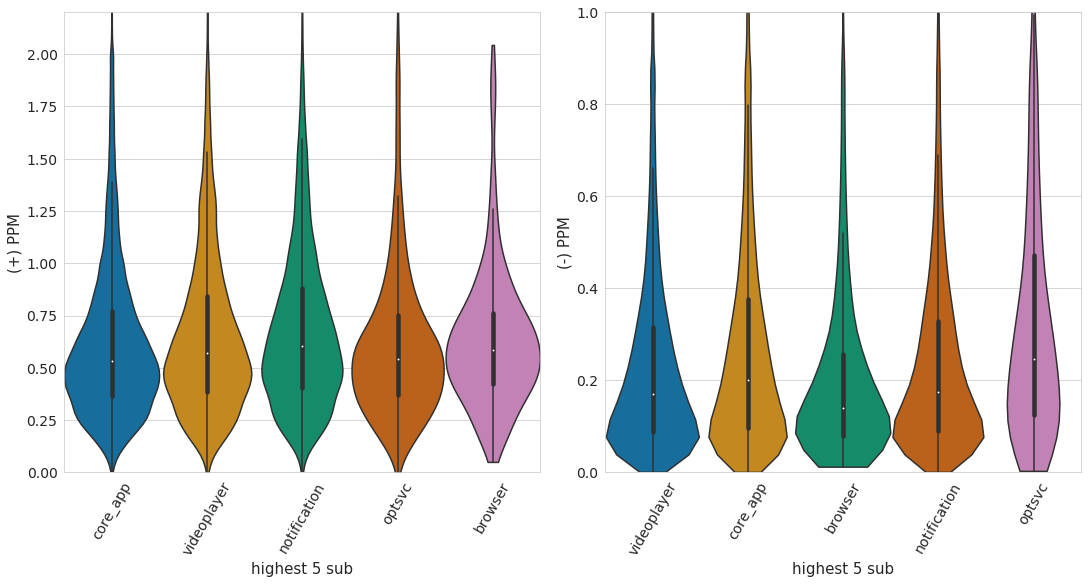

In [16]:
print(dfFacebookGBPos)
print(dfFacebookGBNeg)
boxPlotPPMFiltered(dfFacebook,dfFacebookGBPos,dfFacebookGBNeg,'ppm','sub','sub',2.2,1.0)

              sub  direction  average_ppm       std     count
57   notification        1.0     0.708557  0.416314    1408.0
175   videoplayer        1.0     0.674503  0.394708   86311.0
27    fwkstartlog        1.0     0.666383  0.490787     255.0
11       core_app        1.0     0.630084  0.376984  131982.0
59         optsvc        1.0     0.509424  0.276290     129.0
              sub  direction  average_ppm       std     count
26    fwkstartlog       -1.0     0.333435  0.383615     987.0
58         optsvc       -1.0     0.321598  0.362791     164.0
10       core_app       -1.0     0.296133  0.335405  130591.0
174   videoplayer       -1.0     0.265694  0.298867   90429.0
56   notification       -1.0     0.189973  0.167270    1070.0


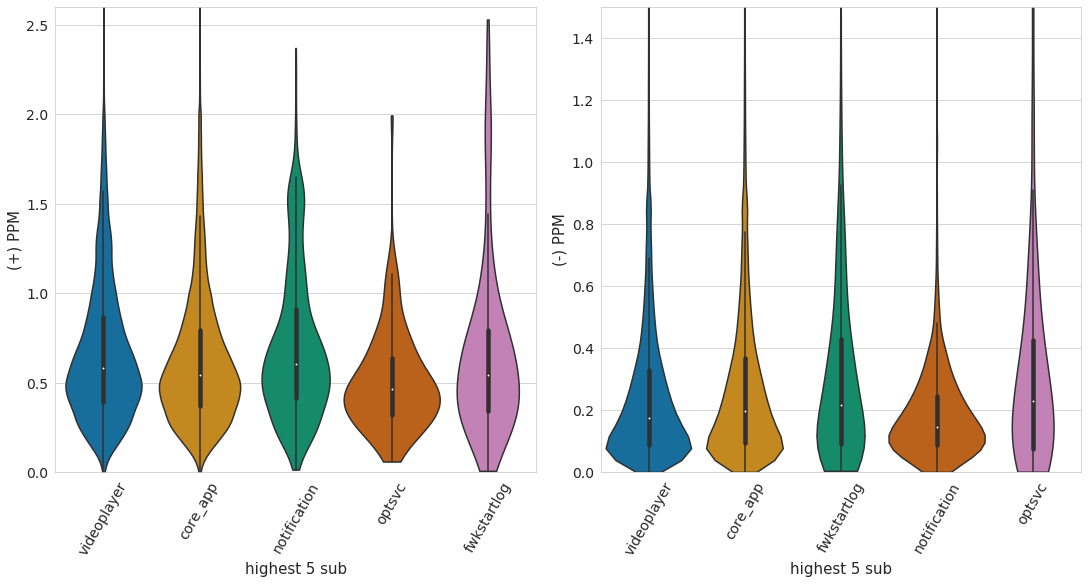

In [17]:
print(dfMessengerGBPos)
print(dfMessengerGBNeg)
boxPlotPPMFiltered(dfMessenger,dfMessengerGBPos,dfMessengerGBNeg,'ppm','sub','sub',2.6,1.5)

             sub  direction  average_ppm       std    count
31      igplayer        1.0     0.724441  0.387121   7775.0
53          mqtt        1.0     0.644606  0.383179  86425.0
11      core_app        1.0     0.634321  0.384484  25274.0
7        browser        1.0     0.610840  0.322028    183.0
175  videoplayer        1.0     0.610591  0.372284  52497.0
             sub  direction  average_ppm       std    count
174  videoplayer       -1.0     0.334004  0.359218  54841.0
10      core_app       -1.0     0.316736  0.357309  31938.0
52          mqtt       -1.0     0.294563  0.331735  82841.0
6        browser       -1.0     0.265360  0.276008    574.0
30      igplayer       -1.0     0.170112  0.152023  12078.0


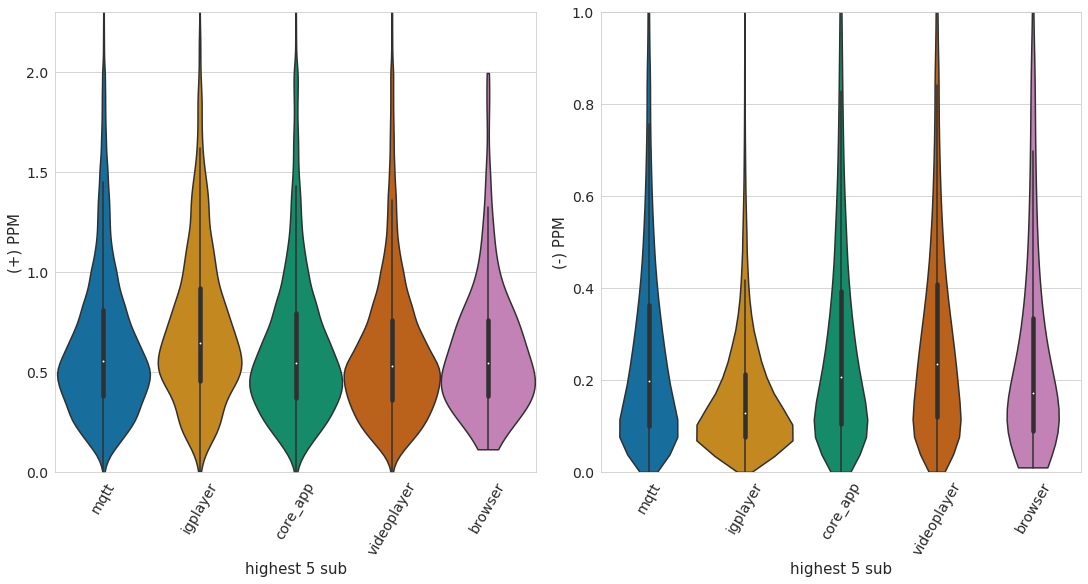

In [18]:
print(dfInstagramGBPos)
print(dfInstagramGBNeg)
boxPlotPPMFiltered(dfInstagram,dfInstagramGBPos,dfInstagramGBNeg,'ppm','sub','sub',2.3,1.0)